Library


In [44]:
import os
import math
import time
import pickle
import numpy as np
import pandas as pd

import scipy.signal
import scipy.fftpack
from scipy.signal import resample_poly

import librosa
import soundfile as sf

import skfuzzy as fuzz
from skfuzzy import control as ctrl

import joblib

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import sounddevice as sd

Path


In [45]:
PATH_MAIN = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# PATH_MAIN = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

PATH_DATASET = f"{PATH_MAIN}/Dataset"
PATH_MODEL = f"{PATH_MAIN}/Model"

Konstanta


In [46]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

Random Seed


In [47]:
RANDOM_SEED = 21

try:
    from sklearn.utils import check_random_state
    random_state = check_random_state(RANDOM_SEED)
except ImportError:
    pass

# Pra-Pemrosesan


In [48]:
def load_file_audio(path):
    audio, sr = sf.read(path)
    return np.array(audio), sr

def prapemrosesan_downmixing(audio):
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio, sr):
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    
    ratio = SAMPLE_RATE / sr
    n_samples = int(np.round(len(audio) * ratio))
    
    x_old = np.linspace(0, 1, len(audio))
    x_new = np.linspace(0, 1, n_samples)
    return np.interp(x_new, x_old, audio), SAMPLE_RATE

def prapemrosesan_padding(audio):
    if np.mod(audio.shape[0], SEGMENT_DURATION) != 0:
        padding = SEGMENT_DURATION - (audio.shape[0] % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding))
    return audio

def prapemrosesan_splitting(audio):
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = []

    for i in range(num_segments):
        start = int(i * OVERLAP_DURATION)
        end = int(start + SEGMENT_DURATION)
        segment = audio[start:end]
        if len(segment) < SEGMENT_DURATION:
            segment = np.pad(segment, (0, SEGMENT_DURATION - len(segment)), mode='constant')
        segments.append(segment)

    return np.array(segments)

# Ekstraksi Fitur


In [49]:
def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_spectral_flatness(segment):
    return np.mean(librosa.feature.spectral_flatness(y=segment))

def get_mfcc(segment):
    return librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)

# Visualization


Satu Hasil


In [50]:
def plot_single(audio_path, list_result):
    audio, sr = load_file_audio(audio_path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    
    time_axis = np.linspace(0, len(audio) / SAMPLE_RATE, len(audio))
    
    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title(os.path.basename(audio_path))
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    for i in range(0, len(list_result)):
        start_time = list_result[i][1][0]
        end_time = list_result[i][1][1]
        if list_result[i][0] == 2:
            plt.axvspan(start_time, end_time, color='blue', alpha=0)
        elif list_result[i][0] == 1:
            plt.axvspan(start_time, end_time, color='red', alpha=0.3)
        elif list_result[i][0] == 0:
            plt.axvspan(start_time, end_time, color='green', alpha=0.3)
    
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

Komparasi 2 Hasil


In [51]:
def plot_compare(path_infer, result_infer, path_label, result_label):
    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    for ax, audio_path, result, title in zip(
        axs, [path_infer, path_label], [result_infer, result_label], ['Hasil Inference', 'Lebel']
    ):
        audio, sr = load_file_audio(audio_path)
        audio = prapemrosesan_downmixing(audio)
        audio, sr = prapemrosesan_resampling(audio, sr)
        
        time_axis = np.linspace(0, len(audio) / SAMPLE_RATE, len(audio))
        ax.plot(time_axis, audio, label="Amplitude", color='blue')
        ax.set_title(f"{title}: {os.path.basename(audio_path)}")
        ax.set_ylabel("Amplitude")
        
        for label, (start_time, end_time) in result:
            if label == 2:
                ax.axvspan(start_time, end_time, color='blue', alpha=0)
            elif label == 1:
                ax.axvspan(start_time, end_time, color='red', alpha=0.3)
            elif label == 0:
                ax.axvspan(start_time, end_time, color='green', alpha=0.3)
        
        ax.set_ylim(-1, 1)
        ax.legend()

    axs[1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

# Load Scaler dan Model


## Scaler


In [52]:
# Scaler Pra-Klasifikasi
p_scl = joblib.load(PATH_MODEL + "/p_scaler.pkl")

# Scaler Klasifikasi
k_scl = joblib.load(PATH_MODEL + "/k_scaler.pkl")

## Model Pra-Klasifikasi


Fuzzy Mamdani


Fungsi


In [53]:
def Antecedent(universe, name):
    return {
        'universe': universe,
        'name': name,
        'mf': {}
    }

def Consequent(universe, name):
    return {
        'universe': universe,
        'name': name,
        'mf': {}
    }

def trapmf(x, params):
    a, b, c, d = params
    y = np.zeros_like(x)
    mask1 = (a <= x) & (x < b)
    mask2 = (b <= x) & (x <= c)
    mask3 = (c < x) & (x <= d)
    y[mask1] = (x[mask1] - a) / (b - a)
    y[mask2] = 1
    y[mask3] = (d - x[mask3]) / (d - c)
    return y

def trimf(x, params):
    a, b, c = params
    y = np.zeros_like(x)
    mask1 = (a <= x) & (x < b)
    mask2 = x == b
    mask3 = (b < x) & (x <= c)
    y[mask1] = (x[mask1] - a) / (b - a)
    y[mask2] = 1
    y[mask3] = (c - x[mask3]) / (c - b)
    return y

def Rule(flatness_key, rms_key, consequent_key):
    return {
        'conditions': (flatness_key, rms_key),
        'consequent': consequent_key
    }

def ControlSystem(rules):
    return {
        'rules': rules
    }

Inisialisasi


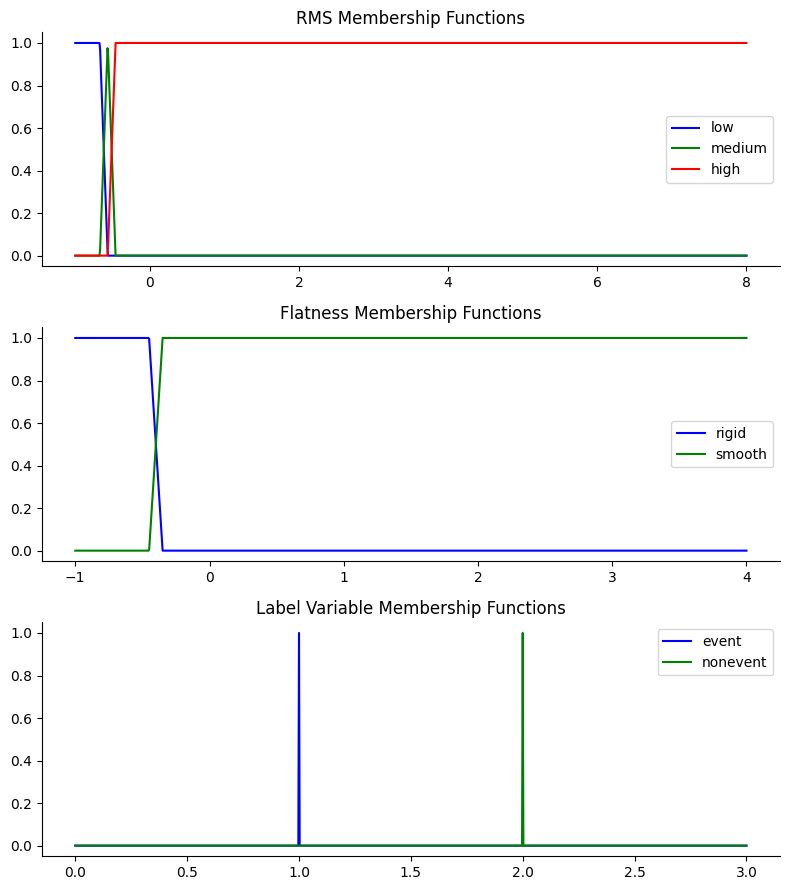

In [54]:
rms_universe = np.linspace(-1, 8, 1000)
flatness_universe = np.linspace(-1, 4, 1000)
label_universe = np.linspace(0, 3, 1000)

rms = ctrl.Antecedent(rms_universe, 'rms')
flatness = ctrl.Antecedent(flatness_universe, 'flatness')
label_var = ctrl.Consequent(label_universe, 'label_var')

rms['low'] = fuzz.trapmf(rms.universe, [-1, -1, -0.67, -0.565])
rms['medium'] = fuzz.trimf(rms.universe, [-0.67, -0.565, -0.46])
rms['high'] = fuzz.trapmf(rms.universe, [-0.565, -0.46, 8, 8])

flatness['rigid'] = fuzz.trapmf(flatness.universe, [-1, -1, -0.45, -0.35])
flatness['smooth'] = fuzz.trapmf(flatness.universe, [-0.45, -0.35, 4, 4])

label_var['event'] = fuzz.trimf(label_var.universe, [1, 1, 1])
label_var['nonevent'] = fuzz.trimf(label_var.universe, [2, 2, 2])

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(rms.universe, fuzz.trapmf(rms.universe, [-1, -1, -0.67, -0.565]), 'b', linewidth=1.5, label='low')
ax0.plot(rms.universe, fuzz.trimf(rms.universe, [-0.67, -0.565, -0.46]), 'g', linewidth=1.5, label='medium')
ax0.plot(rms.universe, fuzz.trapmf(rms.universe, [-0.565, -0.46, 8, 8]), 'r', linewidth=1.5, label='high')
ax0.set_title('RMS Membership Functions')
ax0.legend()

ax1.plot(flatness.universe, fuzz.trapmf(flatness.universe, [-1, -1, -0.45, -0.35]), 'b', linewidth=1.5, label='rigid')
ax1.plot(flatness.universe, fuzz.trapmf(flatness.universe, [-0.45, -0.35, 4, 4]), 'g', linewidth=1.5, label='smooth')
ax1.set_title('Flatness Membership Functions')
ax1.legend()

ax2.plot(label_var.universe, fuzz.trimf(label_var.universe, [1, 1, 1]), 'b', linewidth=1.5, label='event')
ax2.plot(label_var.universe, fuzz.trimf(label_var.universe, [2, 2, 2]), 'g', linewidth=1.5, label='nonevent')
ax2.set_title('Label Variable Membership Functions')
ax2.legend()

for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
plt.show()

In [55]:
rms = Antecedent(np.linspace(-1, 8, 100), 'rms')
flatness = Antecedent(np.linspace(-1, 4, 100), 'flatness')
label_var = Consequent(np.linspace(1, 2, 100), 'label')

rms['mf']['low'] = trapmf(rms['universe'], [-1, -1, -0.67, -0.565])
rms['mf']['medium'] = trimf(rms['universe'], [-0.67, -0.565, -0.46])
rms['mf']['high'] = trapmf(rms['universe'], [-0.565, -0.46, 8, 8])

flatness['mf']['rigid'] = trapmf(flatness['universe'], [-1, -1, -0.45, -0.35])
flatness['mf']['smooth'] = trapmf(flatness['universe'], [-0.45, -0.35, 4, 4])

label_var['mf']['event'] = trimf(label_var['universe'], [1, 1, 1])
label_var['mf']['nonevent'] = trimf(label_var['universe'], [2, 2, 2])

rule1 = Rule('smooth', 'low', 'nonevent')
rule2 = Rule('smooth', 'medium', 'nonevent')
rule3 = Rule('smooth', 'high', 'event')
rule4 = Rule('rigid', 'low', 'nonevent')
rule5 = Rule('rigid', 'medium', 'nonevent')
rule6 = Rule('rigid', 'high', 'event')

mamdani_ctrl = ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])

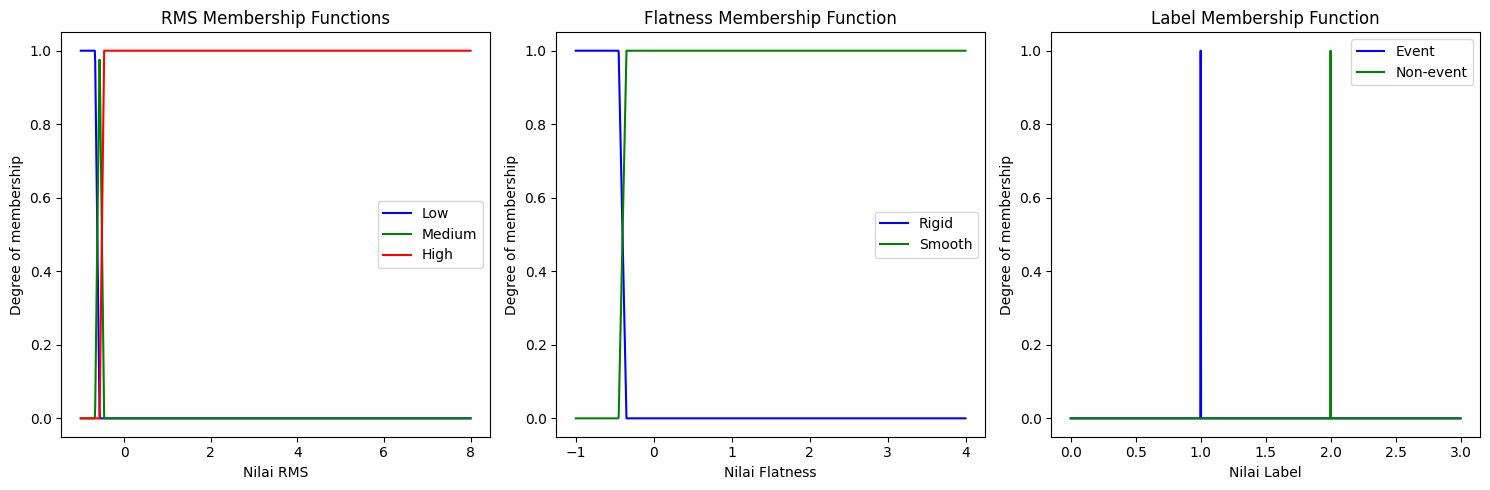

In [56]:
rms_universe = np.linspace(-1, 8, 1000)
flatness_universe = np.linspace(-1, 4, 1000)
label_universe = np.linspace(0, 3, 1000)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rms_universe, trapmf(rms_universe, [-1, -1, -0.67, -0.565]), 'b', linewidth=1.5, label='Low')
plt.plot(rms_universe, trimf(rms_universe, [-0.67, -0.565, -0.46]), 'g', linewidth=1.5, label='Medium')
plt.plot(rms_universe, trapmf(rms_universe, [-0.565, -0.46, 8, 8]), 'r', linewidth=1.5, label='High')
plt.title('RMS Membership Functions')
plt.ylabel('Degree of membership')
plt.xlabel('Nilai RMS')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(flatness_universe, trapmf(flatness_universe, [-1, -1, -0.45, -0.35]), 'b', linewidth=1.5, label='Rigid')
plt.plot(flatness_universe, trapmf(flatness_universe, [-0.45, -0.35, 4, 4]), 'g', linewidth=1.5, label='Smooth')
plt.title('Flatness Membership Function')
plt.ylabel('Degree of membership')
plt.xlabel('Nilai Flatness')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(label_universe, trimf(label_universe, [1, 1, 1]), 'b', linewidth=1.5, label='Event')
plt.plot(label_universe, trimf(label_universe, [2, 2, 2]), 'g', linewidth=1.5, label='Non-event')
plt.title('Label Membership Function')
plt.ylabel('Degree of membership')
plt.xlabel('Nilai Label')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
def fuzzy_inference(rms_value, flatness_value):
    rms_degrees = {k: np.interp(rms_value, rms['universe'], v) for k, v in rms['mf'].items()}
    flatness_degrees = {k: np.interp(flatness_value, flatness['universe'], v) for k, v in flatness['mf'].items()}
    label_universe = label_var['universe']
    aggregated_output = np.zeros_like(label_universe)

    for rule in mamdani_ctrl['rules']:
        flatness_key, rms_key = rule['conditions']
        consequent_key = rule['consequent']
        degree = min(flatness_degrees[flatness_key], rms_degrees[rms_key])
        aggregated_output = np.maximum(aggregated_output, np.minimum(degree, label_var['mf'][consequent_key]))

    return 1.5 if np.sum(aggregated_output) == 0 else np.sum(label_universe * aggregated_output) / np.sum(aggregated_output)

def p_mamdani(X):
    return int(round(fuzzy_inference(*X[0])))

Supervised


In [58]:
# Logistic Regression
p_lr = joblib.load(PATH_MODEL + "/p_lr.pkl")

# Descision Tree
p_dt = joblib.load(PATH_MODEL + "/p_dt.pkl")

# LGBM Classifier
p_lgbm = joblib.load(PATH_MODEL + "/p_lgbm.pkl")

## Model Klasifikasi


In [59]:
# LGBM
k_lgbm = joblib.load(PATH_MODEL + "/k_lgbm.pkl")

# CNN
k_mlp = joblib.load(PATH_MODEL + "/k_mlp.pkl")

# Model Complete


In [60]:
# LGBM
a_lgbm = joblib.load(PATH_MODEL + "/a_lgbm.pkl")

# CNN
a_mlp = joblib.load(PATH_MODEL + "/a_mlp.pkl")

# Main


## Single Audio Inference


In [61]:
def single_inference(path, models):
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)
    
    list_result = []
    time = 0
    for segment in segments:
        timestamp = [time * 0.5, (time*0.5) + 1]
        time += 1
        
        rms = get_rms(segment)
        flatness = get_spectral_flatness(segment)
        rms_scaled, flatness_scaled = p_scl.transform([[rms, flatness]])[0]
        
        if len(models) == 2:
            if models[0] == "mamdani":
                label = p_mamdani([[rms_scaled, flatness_scaled]])
            elif models[0] == "lr":
                label = p_lr.predict([[rms_scaled, flatness_scaled]])[0]
            elif models[0] == "dt":
                label = p_dt.predict([[rms_scaled, flatness_scaled]])[0]
            elif models[0] == "lgbm":
                label = p_lgbm.predict([[rms_scaled, flatness_scaled]])[0]

            if label != 2:
                mfcc = get_mfcc(segment)
                mfcc = np.array(mfcc)
                mfcc = mfcc.reshape(1, -1)
                mfcc_scaled = k_scl.transform(mfcc)
                
                if models[1] == "lgbm":
                    label = k_lgbm.predict(mfcc_scaled)[0]
                elif models[1] == "mlp":
                    label = k_mlp.predict(mfcc_scaled)[0]
        
        else:
            mfcc = get_mfcc(segment)
            mfcc = np.array(mfcc)
            mfcc = mfcc.reshape(1, -1)
            mfcc_scaled = k_scl.transform(mfcc)
            
            if models == "lgbm":
                label = a_lgbm.predict(mfcc_scaled)
            elif models == "mlp":
                label = a_mlp.predict(mfcc_scaled)
        
        list_result.append([label, timestamp])
    
    return list_result

Running


Data Test


C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


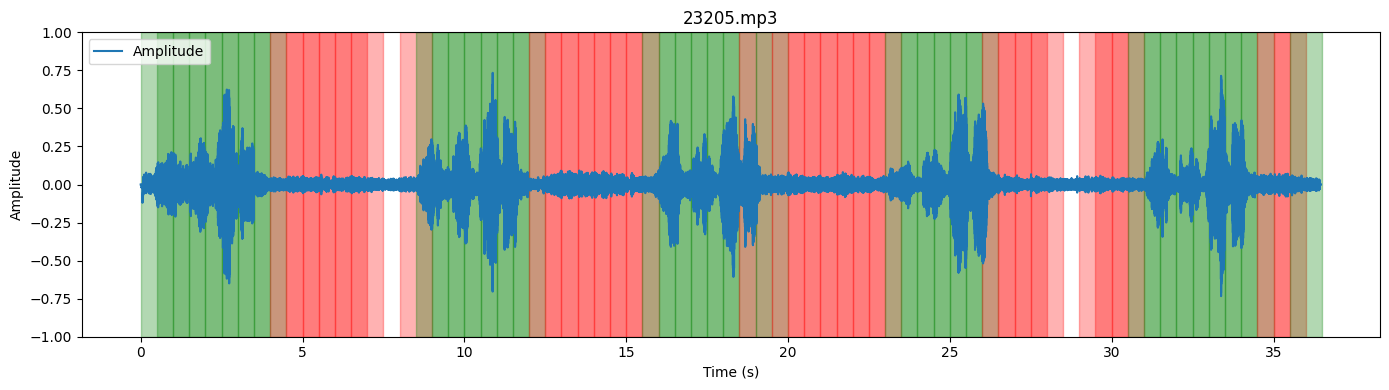

Runtime:  2.062178373336792


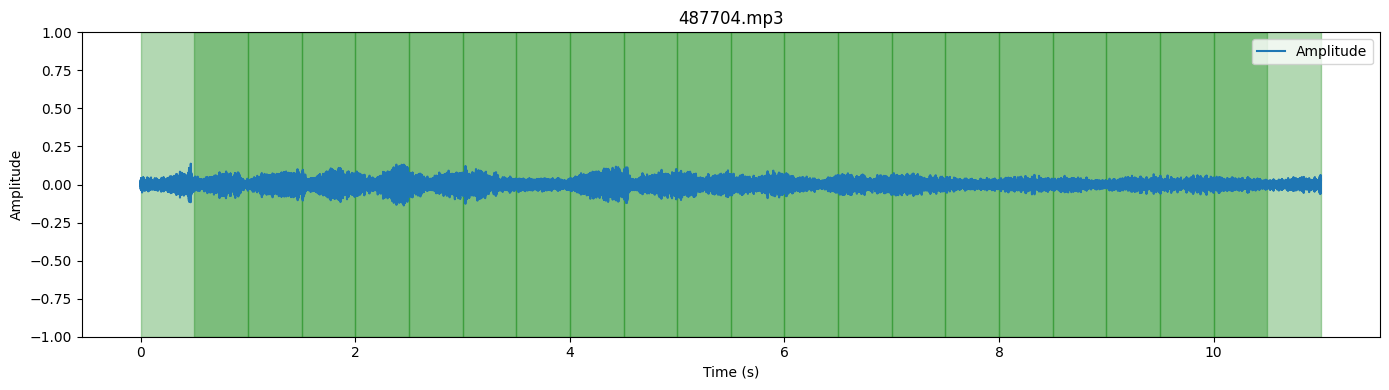

Runtime:  0.6381404399871826


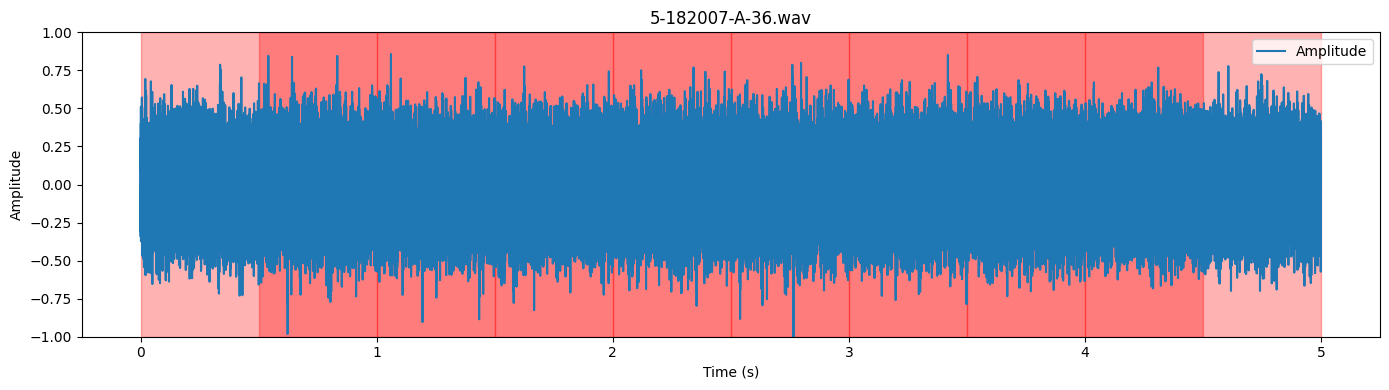

Runtime:  0.2718231678009033


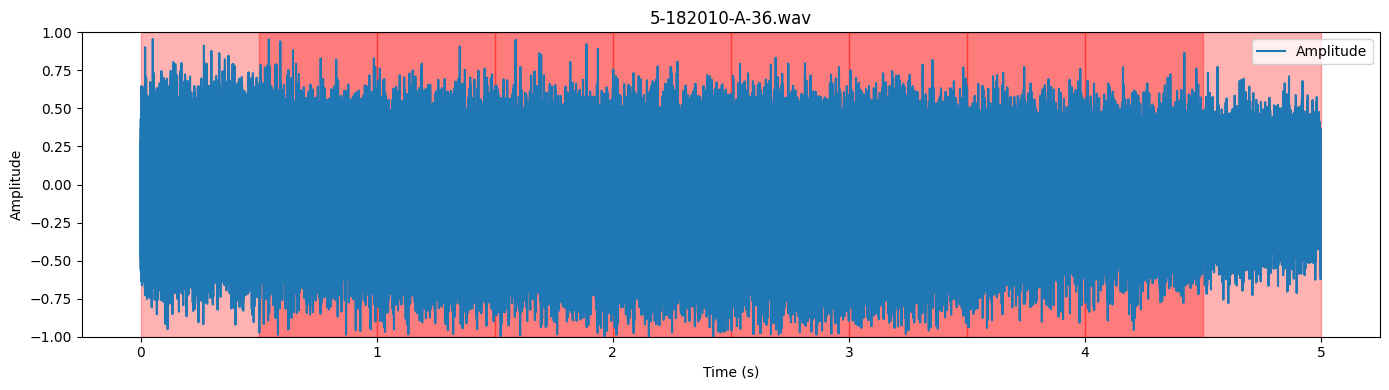

Runtime:  0.2606489658355713


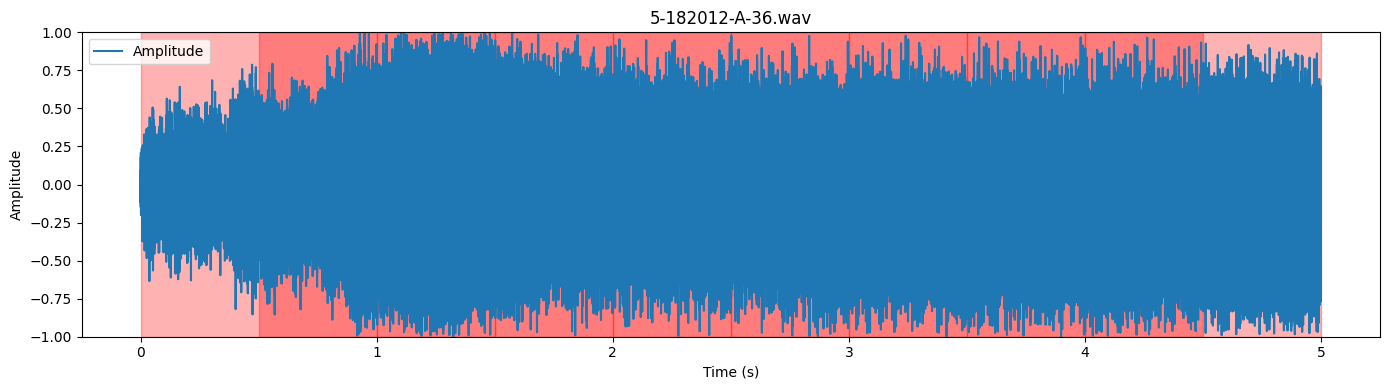

Runtime:  0.25307464599609375


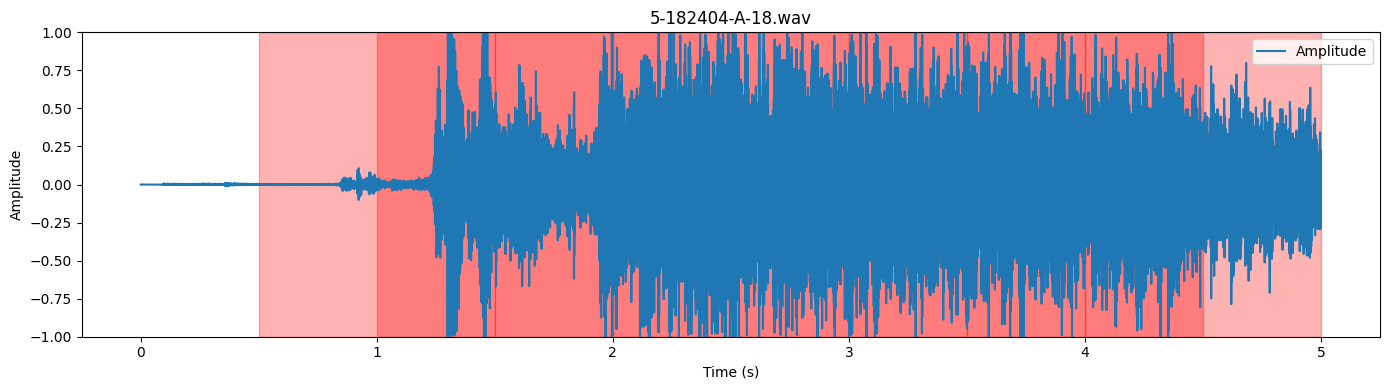

Runtime:  0.24356603622436523


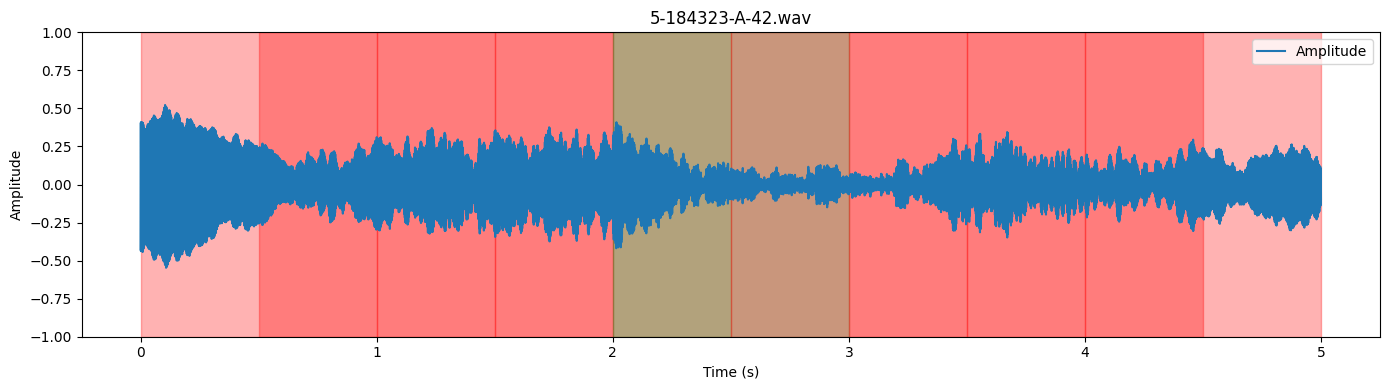

Runtime:  0.31904125213623047


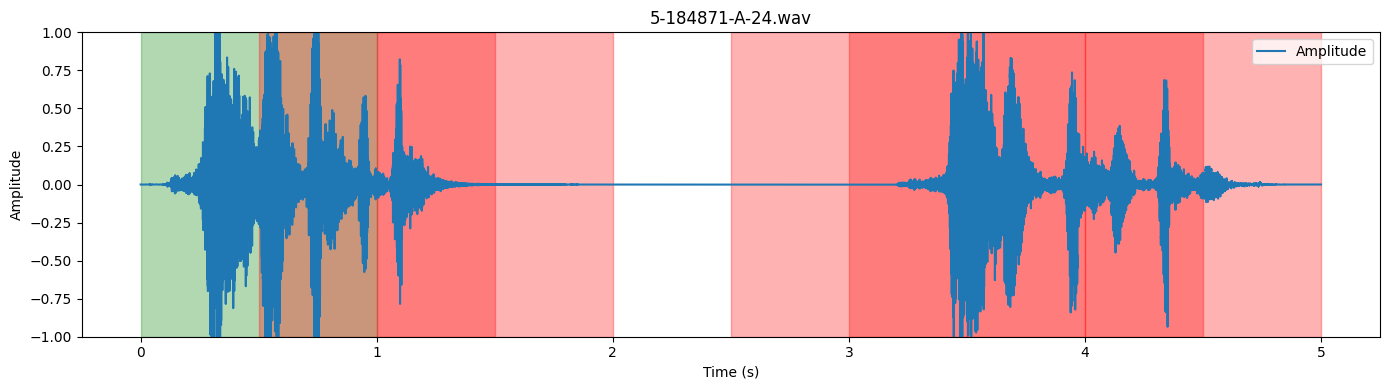

Runtime:  0.23966670036315918


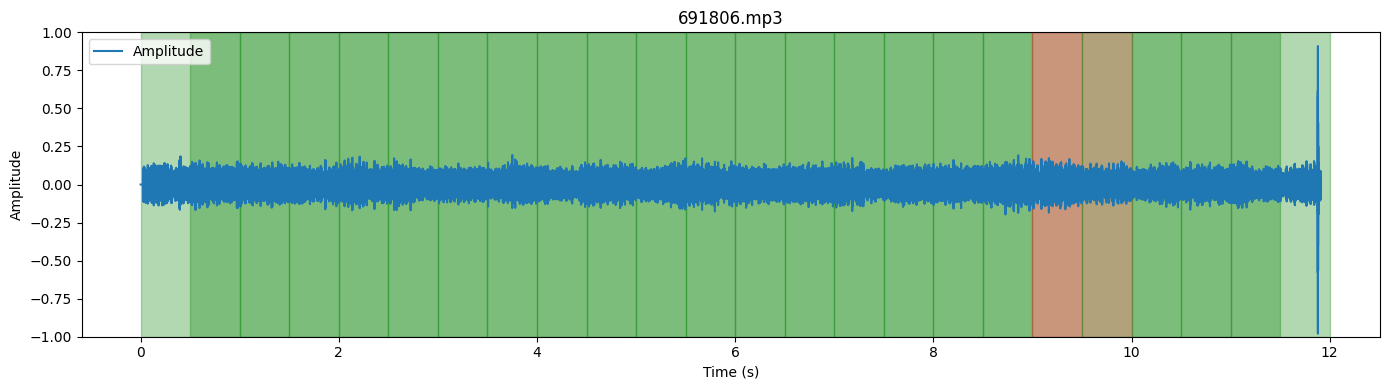

Runtime:  0.6983678340911865


In [62]:
audio_dir = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\Data_Test"
time_list_double = []

for file in os.listdir(audio_dir):
    file_path = os.path.join(audio_dir, file)
    start_time = time.time()
    hasil_inferensi = single_inference(file_path, ["mamdani", "lgbm"])
    end_time = time.time()
    plot_single(file_path, hasil_inferensi)
    print("Runtime: ", end_time - start_time)
    time_list_double.append(end_time - start_time)

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


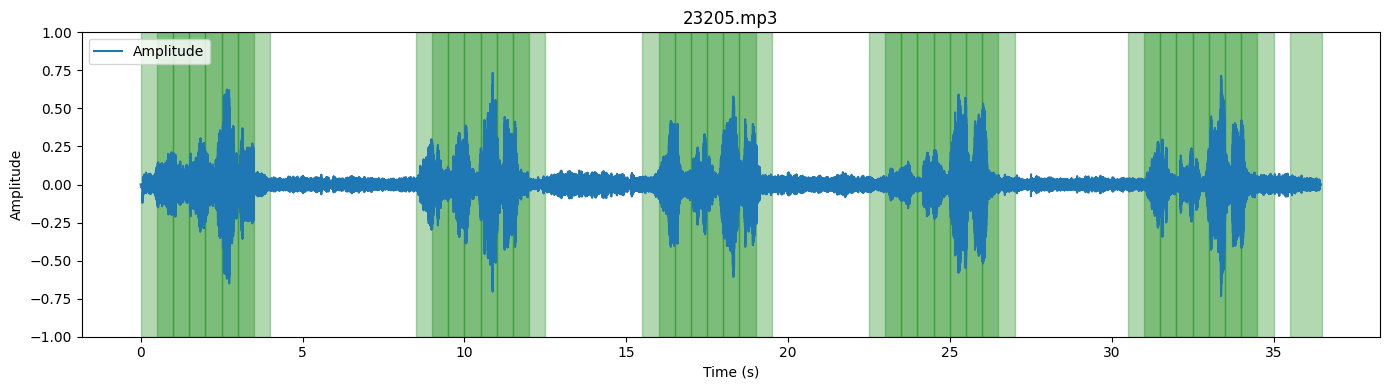

Runtime:  2.0991179943084717


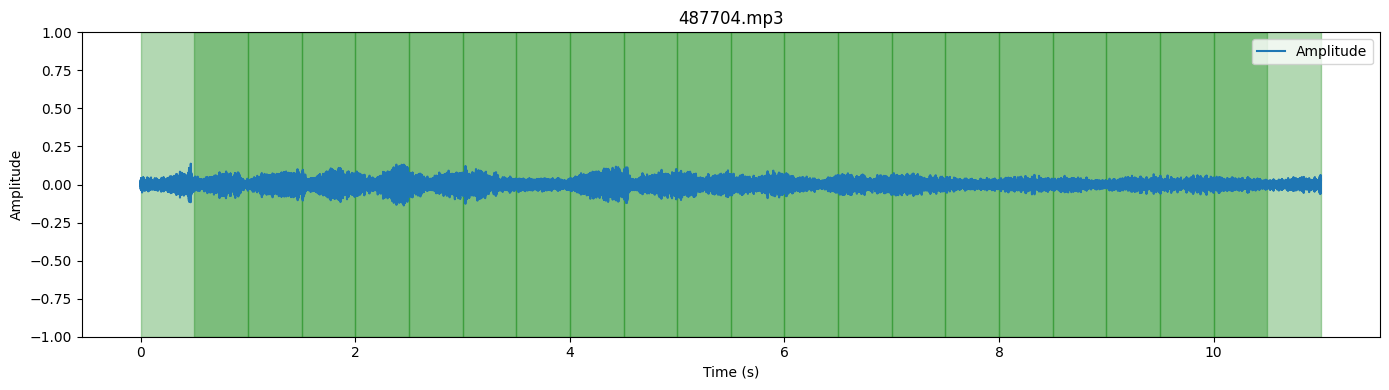

Runtime:  0.6676380634307861


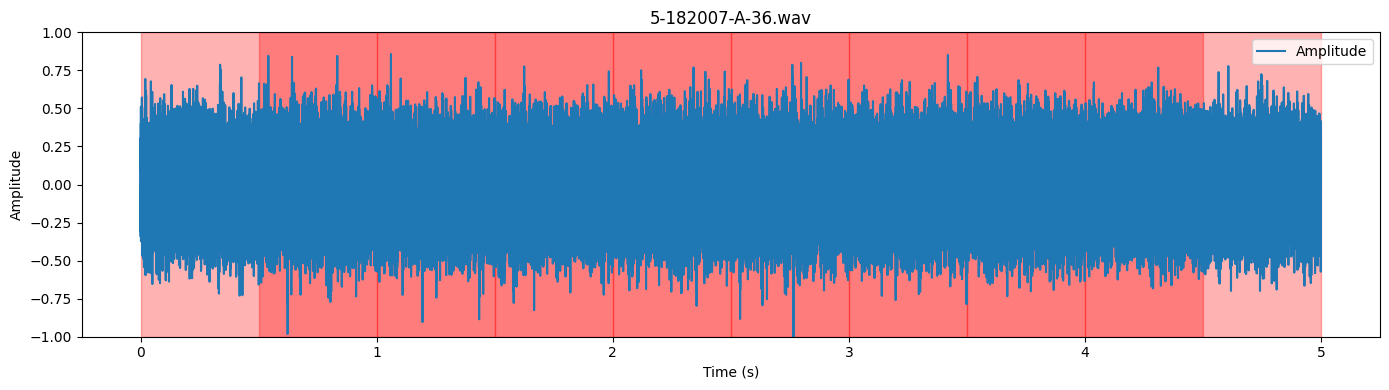

Runtime:  0.2775387763977051


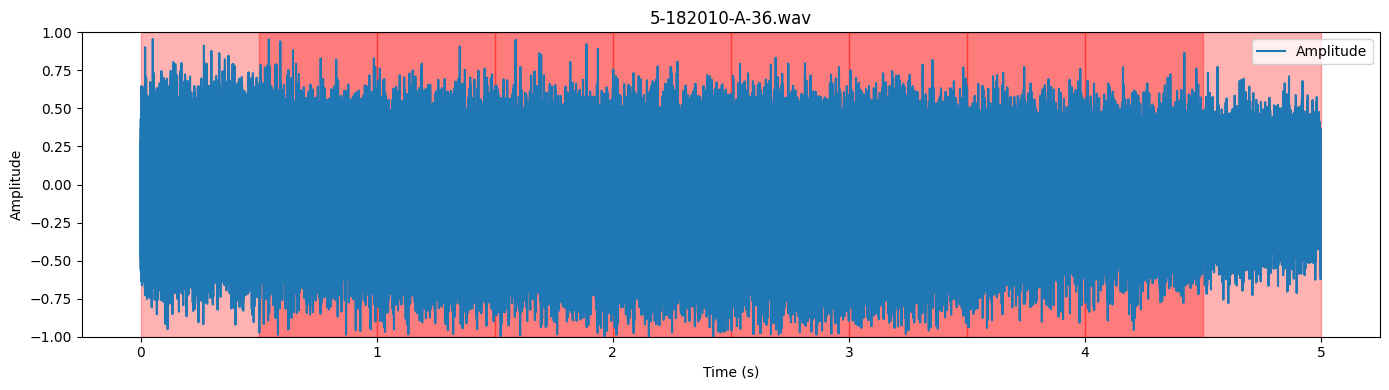

Runtime:  0.28388023376464844


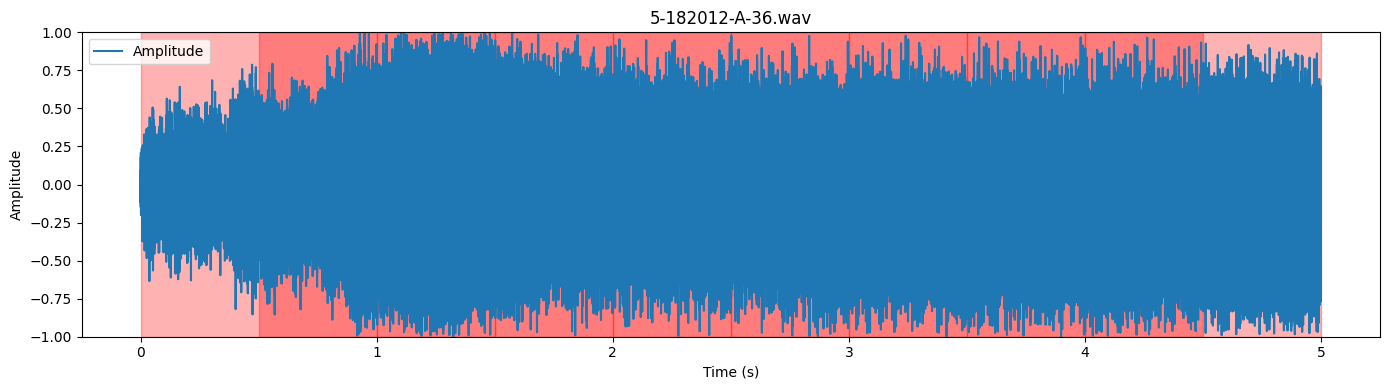

Runtime:  0.29916834831237793


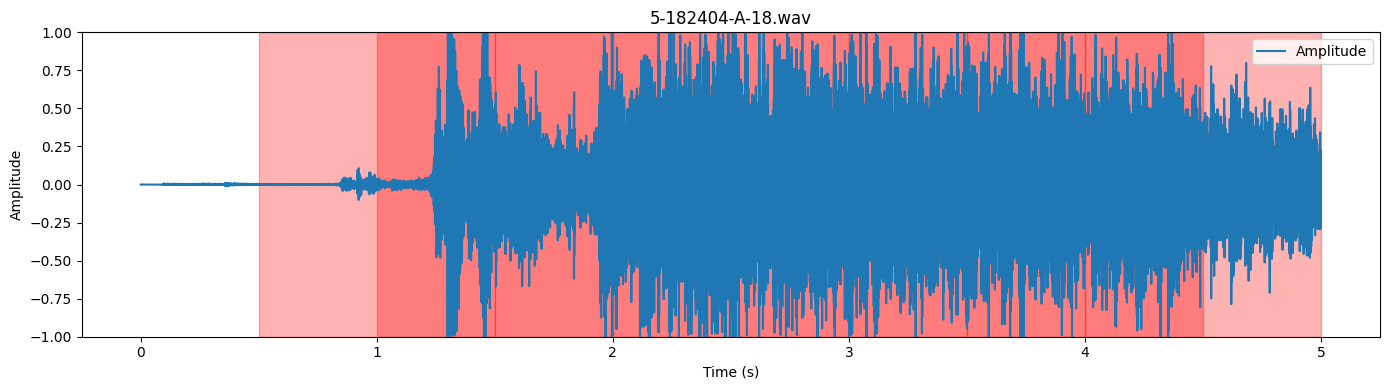

Runtime:  0.28926730155944824


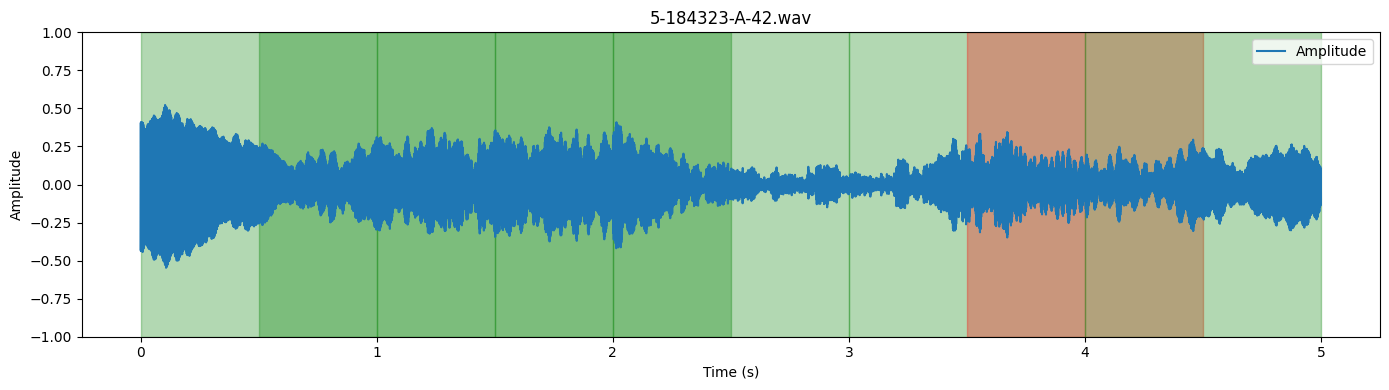

Runtime:  0.2891378402709961


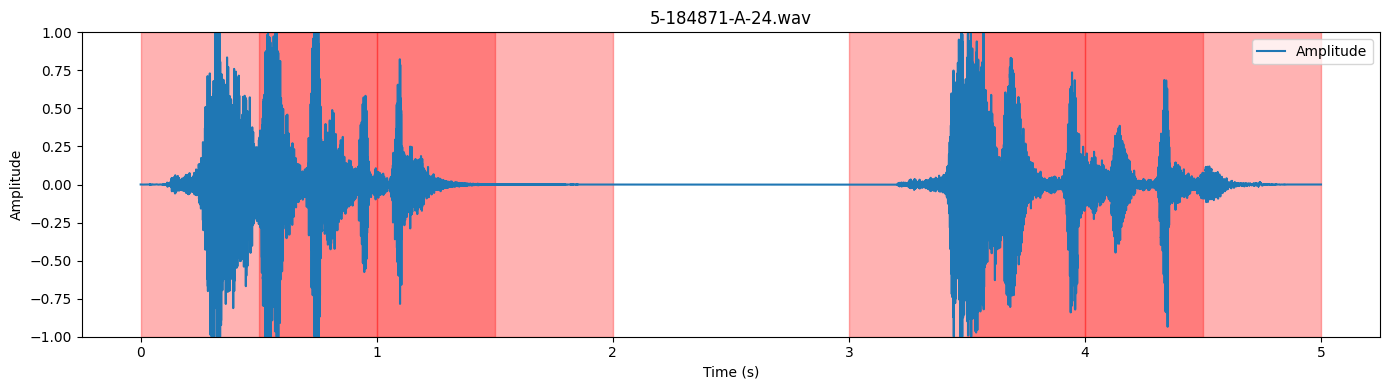

Runtime:  0.28048133850097656


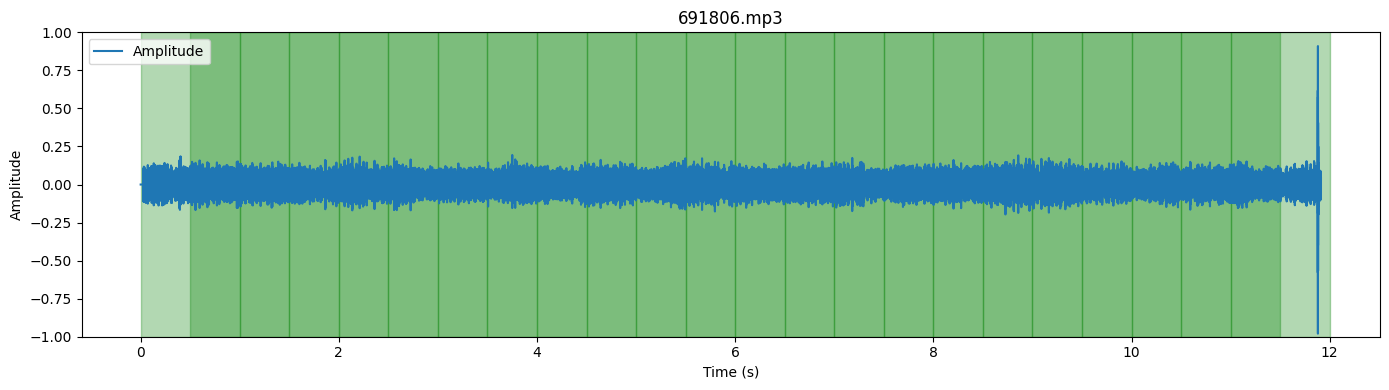

Runtime:  0.802623987197876


In [63]:
audio_dir = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\Data_Test"
time_list_singel = []

for file in os.listdir(audio_dir):
    file_path = os.path.join(audio_dir, file)
    start_time = time.time()
    hasil_inferensi = single_inference(file_path, "lgbm")
    end_time = time.time()
    plot_single(file_path, hasil_inferensi)
    print("Runtime: ", end_time - start_time)
    time_list_singel.append(end_time - start_time)

In [64]:
df_test_runtime = pd.DataFrame({
    "Double Inference": time_list_double,
    "Single Inference": time_list_singel,
    "Difference": np.array(time_list_double) - np.array(time_list_singel)
})

In [65]:
df_test_runtime

,Double Inference,Single Inference,Difference
0,2.062178,2.099118,-0.036940
1,0.638140,0.667638,-0.029498
2,0.271823,0.277539,-0.005716
3,0.260649,0.283880,-0.023231
4,0.253075,0.299168,-0.046094
5,0.243566,0.289267,-0.045701
6,0.319041,0.289138,0.029903
7,0.239667,0.280481,-0.040815
8,0.698368,0.802624,-0.104256


# Analisa


Load Dataset Anotasi


In [66]:
with open(f"{PATH_DATASET}/dataset_raw_conc.pkl", "rb") as f:
    dataset_raw_conc = pickle.load(f)

Running


In [67]:
dataset_raw_conc_adj = []

for data_raw in dataset_raw_conc:
    label_timestamp = []
    for i in range(0, len(data_raw['label'])):
        label_timestamp.append([data_raw['label'][i], data_raw['timestamp'][i]])
    dataset_raw_conc_adj.append({
        'name': data_raw['name'],
        'path': data_raw['path'],
        'label_timestamp': label_timestamp
    })

In [68]:
list_result = []

for data_raw in dataset_raw_conc_adj:
    hasil_inferensi = single_inference(data_raw["path"], ["mamdani", "lgbm"])
    path_infer = data_raw["path"]
    result_infer = hasil_inferensi
    path_label = data_raw["path"]
    result_label = data_raw["label_timestamp"]
    
    list_result.append({
        "path": path_infer,
        "pred": result_infer,
        "label": result_label
    })
    
    # plot_compare(path_infer, result_infer, path_label, result_label)

In [69]:
y_all = []

for result in list_result:
    y_pred = []
    for i in range(0, len(result)):
        pred = result["pred"]
        label = result["label"]
        for j in range(0, len(pred)):
            if label[j][1] == pred[j][1]:
                y_all.append({
                    "path": result["path"],
                    "pred": pred[j][0],
                    "label": label[j][0]
                })

In [70]:
y_pred_all = [y["pred"] for y in y_all]
y_label_all = [y["label"] for y in y_all]

In [71]:
print(f"Accuracy: {accuracy_score(y_label_all, y_pred_all)}")
print(f"Recall: {recall_score(y_label_all, y_pred_all, average='macro')}")
print(f"Precision: {precision_score(y_label_all, y_pred_all, average='macro')}")
print(f"F1-score: {f1_score(y_label_all, y_pred_all, average='macro')}")
print(f"Confusion Matrix:\n {confusion_matrix(y_label_all, y_pred_all)}")

Accuracy: 0.8344481605351171
Recall: 0.8379428609879755
Precision: 0.8317233073158437
F1-score: 0.8334715670587792
Confusion Matrix:
 [[1509  114  333]
 [ 267 1734    0]
 [   3  174 1248]]


# Run All Model


In [72]:
list_model = [
    ['mamdani', 'mlp'],
    ['mamdani', 'lgbm'],
    ['lr', 'mlp'],
    ['lr', 'lgbm'],
    ['dt', 'mlp'],
    ['dt', 'lgbm'],
    'lgbm',
    'mlp'
]

In [73]:
skor_hasil = []

for models in list_model:
    list_result = []

    for data_raw in dataset_raw_conc_adj:
        runtime_start = time.time()
        hasil_inferensi = single_inference(data_raw["path"], models)
        runtime_end = time.time()
        runtime = runtime_end - runtime_start 
        path_infer = data_raw["path"]
        result_infer = hasil_inferensi
        path_label = data_raw["path"]
        result_label = data_raw["label_timestamp"]
        
        list_result.append({
            "path": path_infer,
            "pred": result_infer,
            "label": result_label,
            "runtime": runtime
        })
        
    y_all = []

    for result in list_result:
        y_pred = []
        for i in range(0, len(result)):
            pred = result["pred"]
            label = result["label"]
            for j in range(0, len(pred)):
                if label[j][1] == pred[j][1]:
                    y_all.append({
                        "path": result["path"],
                        "pred": pred[j][0],
                        "label": label[j][0]
                    })
    y_pred_all = [y["pred"] for y in y_all]
    y_label_all = [y["label"] for y in y_all]

    print(f"\nModels {models}")
    print(f"Accuracy: {accuracy_score(y_label_all, y_pred_all)}")
    print(f"Recall: {recall_score(y_label_all, y_pred_all, average='weighted')}")
    print(f"Precision: {precision_score(y_label_all, y_pred_all, average='weighted')}")
    print(f"F1-score: {f1_score(y_label_all, y_pred_all, average='weighted')}")
    print(f"Confusion Matrix:\n {confusion_matrix(y_label_all, y_pred_all)}")
    print(f"Average Runtime: {np.mean([x['runtime'] for x in list_result])}")
    print(f"Median Runtime: {np.median([x['runtime'] for x in list_result])}")
    
    skor_hasil.append({
        "models": models,
        "accuracy": accuracy_score(y_label_all, y_pred_all),
        "recall": recall_score(y_label_all, y_pred_all, average='weighted'),
        "precision": precision_score(y_label_all, y_pred_all, average='weighted'),
        "f1_score": f1_score(y_label_all, y_pred_all, average='weighted'),
        "confusion_matrix": confusion_matrix(y_label_all, y_pred_all),
        "average_runtime": np.mean([x['runtime'] for x in list_result]),
        "median_runtime": np.median([x['runtime'] for x in list_result])
    })


Models ['mamdani', 'mlp']
Accuracy: 0.806577480490524
Recall: 0.806577480490524
Precision: 0.8125072957494913
F1-score: 0.8069127034461214
Confusion Matrix:
 [[2092   72  444]
 [ 636 2032    0]
 [  48  188 1664]]
Average Runtime: 0.5644843101501464
Median Runtime: 0.25873231887817383

Models ['mamdani', 'lgbm']
Accuracy: 0.8344481605351171
Recall: 0.8344481605351171
Precision: 0.8361176842296993
F1-score: 0.8340194950146642
Confusion Matrix:
 [[2012  152  444]
 [ 356 2312    0]
 [   4  232 1664]]
Average Runtime: 0.658038392663002
Median Runtime: 0.28548336029052734

Models ['lr', 'mlp']
Accuracy: 0.7987736900780379
Recall: 0.7987736900780379
Precision: 0.8020056261781602
F1-score: 0.798970837990839
Confusion Matrix:
 [[2156   72  380]
 [ 636 2032    0]
 [  60  296 1544]]
Average Runtime: 0.5807348757982254
Median Runtime: 0.2503770589828491

Models ['lr', 'lgbm']
Accuracy: 0.8255295429208472
Recall: 0.8255295429208472
Precision: 0.8261889021608652
F1-score: 0.8253038499871026
Confusi

In [74]:
df_result = pd.DataFrame(skor_hasil, columns=["models", "accuracy", "recall", "precision", "f1_score", "average_runtime", "median_runtime"])

In [75]:
df_result.sort_values("accuracy", ascending=True)

,models,accuracy,recall,precision,f1_score,average_runtime,median_runtime
2,"[lr, mlp]",0.798774,0.798774,0.802006,0.798971,0.580735,0.250377
0,"[mamdani, mlp]",0.806577,0.806577,0.812507,0.806913,0.564484,0.258732
4,"[dt, mlp]",0.813266,0.813266,0.831856,0.812785,0.526467,0.241963
3,"[lr, lgbm]",0.825530,0.825530,0.826189,0.825304,0.628302,0.289145
1,"[mamdani, lgbm]",0.834448,0.834448,0.836118,0.834019,0.658038,0.285483
5,"[dt, lgbm]",0.835563,0.835563,0.849953,0.834844,0.576642,0.280706
7,mlp,0.875139,0.875139,0.890480,0.876281,0.657612,0.248767
6,lgbm,0.903567,0.903567,0.906574,0.903762,0.710472,0.288346


In [76]:
df_result.to_excel("Result_Kombinasi_Model.xlsx", index=False)

with open(f"{PATH_MAIN}/Result_Kombinasi_Model.pkl", "wb") as f:
    pickle.dump(skor_hasil, f)